In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import cv2 as cv2
from scipy.integrate import odeint
import scipy.optimize as optimize
from matplotlib.animation import FuncAnimation # animate by repeatedly calling a function
from IPython import display # manipulate notebook output

In [2]:
fig1 = plt.figure(figsize=(5,8))
line1, = plt.plot([])
line2, = plt.plot([])
plt.xlabel('[Species 1]')
plt.ylabel('[Species 2]')
plt.title('Effects of Diffusion on Oscillation Stability')
plt.xlim(0, 2)
plt.ylim(0, 2.5)

du, dv = 1, 1 
eps, q, f = 0.2, 10e-3, 1.0 # Du controls the convergence of the reaction. It is the diffusion constant

# these are the Oregonator equations 
def oregonator(r,t):
    u, v = r
    fu = (1/eps)*(u*(1-u) - ((u-q)/(u+q))*f*v + Du*du**2)
    fv = u - v + Du*dv**2
    return fu, fv
    
init = [0, 0] # initial values for odeint
t = np.linspace(0, 20, 10000)

Du_array = np.linspace(10e-6, 2, 100) # list of values used for the diffusion constant
u_concentration, v_concentration = [], []
for i in range(len(Du_array)):
    Du = Du_array[i]
    A = odeint(oregonator, init, t)
    x, y = A.T
    u_concentration.append(x) # append sweeps to lists
    v_concentration.append(y)
    
def animate(frame):
    line1.set_data([u_concentration[frame], v_concentration[frame]]) # animate [u] vs. [v] plot

anim = FuncAnimation(fig1, animate, frames=len(Du_array), interval=30)
video = anim.to_html5_video()
plt.close()
display.HTML(video)   
    


In [3]:
fig2 = plt.figure(figsize=(8,4))
line2, = plt.plot([])
line3, = plt.plot([])
plt.xlabel('Time')
plt.ylabel('[Relative Concentration]')
plt.title('Damped Oscillations with Decreased Diffusivity')
plt.xlim(0, 10)
plt.ylim(0, 3)

du, dv = 1, 1
eps, q, f = 0.2, 10e-3, 1.0 # Du controls the convergence of the reaction. It is a diffusion constant

def oregonator(r,t):
    u, v = r
    fu = (1/eps)*(u*(1-u) - ((u-q)/(u+q))*f*v + Du*du**2)
    fv = u - v + Du*dv**2
    return fu, fv
    
init = [0, 0] # initial values for odeint
t = np.linspace(0, 10, 10000)
Du_array = np.linspace(10e-6, 2, 1000) # list of values used for the diffusion constant
u_concentration, v_concentration = [], []
for i in range(len(Du_array)):
    Du = Du_array[i]
    A = odeint(oregonator, init, t)
    x, y = A.T
    u_concentration.append(x)
    v_concentration.append(y)

def animate(frame):
    line2.set_data([t, u_concentration[frame]])
    line3.set_data([t, v_concentration[frame]])

anim = FuncAnimation(fig2, animate, frames=len(Du_array), interval=20)
video = anim.to_html5_video()
plt.close()
display.HTML(video)   
    


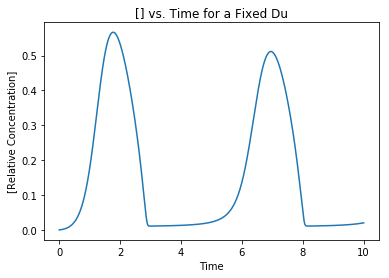

[============================================================] 630/629

In [4]:
Du_sweep = 1
plt.xlabel('Time')
plt.ylabel('[Relative Concentration]')
plt.title('[] vs. Time for a Fixed Du')
plt.plot(t, u_concentration[Du_sweep])
plt.show()
A = []
C1 = u_concentration[Du_sweep].copy() # use the concentration curve of species u for a fixed value of Du
C = C1[::60] # down sample to lighten computational load
dim = len(C)
timesteps = int(dim/2) # make the number of time steps equal to 1/2 the length of C
max_val = max(C) # used to normalize values between 0 and 255
time = np.linspace(0, timesteps, timesteps+1) # used to help find a reasonable step size for phi (see for loop in line 17)
im = np.zeros((dim, dim)) # creates the blank image on which to draw the spiral
book = [] # list for keeping all of the rotated images together

for i in time: 
    phi = i/(max(time))*2*np.pi # calculate by how much to rotate the 'phaser' along which C is overlayed
    B = np.roll(C, -1, axis=0) # after rotating the 'phaser', roll the C array so that the peaks in C are shifted along the radius by 1 step
    A.append(B.copy())
    C = B    
    for j in time:
        x_comp = round(j*np.cos(phi-np.pi)) # calculate the x and y coordinates cooresponding to each pixel along the new radius
        y_comp = round(j*np.sin(phi-np.pi))
        im[round(dim/2)-1+int(x_comp), round(dim/2)-1+int(y_comp)] = C[int(j)]/max_val*255 # scale the values between 0 and 255

kernel = np.ones((8,8),np.float32)/64
im = cv2.filter2D(im,-1,kernel) # apply averaging filter to remove lines caused by bigger steps 0 to 360  
        
rows, cols = im.shape
for angle in np.arange(0, 2*np.pi, .01): # rotate the spiral through 360 degrees and append each image to book
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) # calculate the affine matrix
    im = (cv2.warpAffine(im,M,(cols,rows))) # apply affine transform
    book.append(im)

fig = plt.figure(figsize=(8,8))
plt.xlim(-10,10)
plt.ylim(-10,10)
line = plt.imshow([[]], extent=(-10,10,-10,10))

def animate(frame):
    line.set_data(book[frame]) 
    progress.progress += 1

progress = display.ProgressBar(len(book))
progress.display()
anim = FuncAnimation(fig, animate, frames=len(book), interval=20)
video = anim.to_html5_video()
plt.close()
display.HTML(video)  